In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import arviz as az

In [2]:
# INITIAL POPULATION OF THE SEEDS 

SEEDS = 1000
Z_MAX = 5

# This is UN-Real Universe

## Everything is Gaussian (merger rate == population distribution == detection rate)

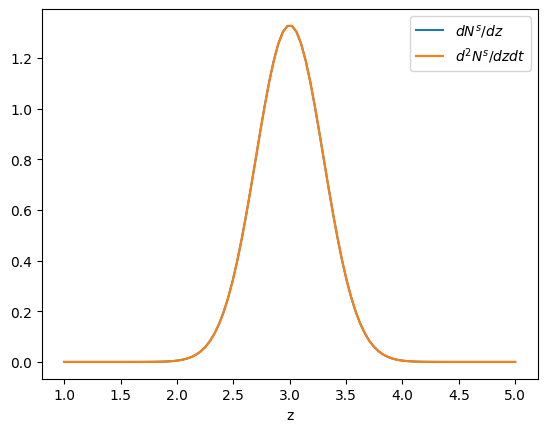

In [3]:

MU_DISTRIBUTION_POP = 3
SIGMA_DISTRIBUTION_POP = .3

def population_dist(z):
    return st.norm.pdf(x=z, loc=MU_DISTRIBUTION_POP, scale=SIGMA_DISTRIBUTION_POP)

def merger_rate(z):
    # merger rate depends on the population distribution
    # the parameters of merger rate also depend on the 
    # parameter of the population distribution
    
    return population_dist(z)

# TESTING DISTRIBUTIONS

z = np.linspace(1, Z_MAX, 100)
plt.plot(z, population_dist(z), label='$dN^s/dz$')
plt.plot(z, merger_rate(z), label='$d^2N^s/dzdt$')
plt.xlabel('z')
plt.legend()
del z

Text(0, 0.5, '$d^2N^s_\\uparrow/dzdt$')

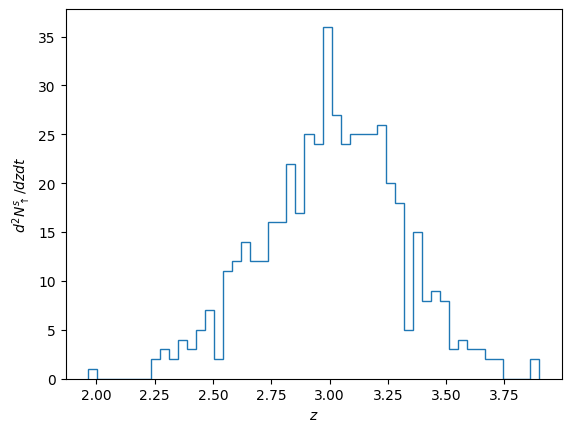

In [4]:
# DISTRIBUTION FOR SOURCE DETECTION

z_events = np.random.choice(np.linspace(0, Z_MAX, SEEDS//2), size=SEEDS//2, p=merger_rate(np.linspace(0, Z_MAX, SEEDS//2)) / np.sum(merger_rate(np.linspace(0, Z_MAX, SEEDS//2))))
plt.hist(z_events, bins=50, fill=False, histtype='step')
plt.xlabel('$z$')
plt.ylabel('$d^2N^s_\\uparrow/dzdt$')

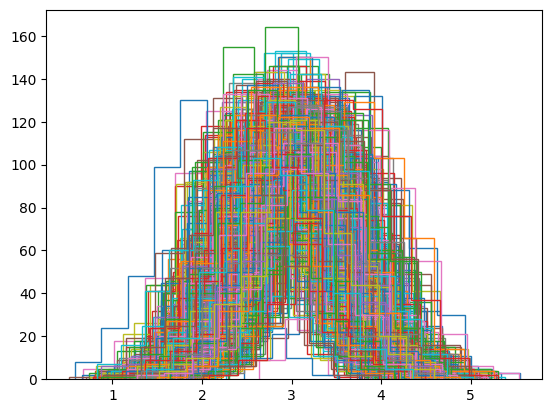

In [5]:
# DEFINING THE POSTERIORS ON Z

LEN_DATA = 500
Z_SRC = np.empty((SEEDS//2, LEN_DATA))
for i in range(SEEDS//2):
    Z_SRC[i] = st.norm(loc=z_events[i], scale=0.5).rvs(size=LEN_DATA)

# PLOTTING ALL THE EVENTS' Z

for i in range(SEEDS//2):
    plt.hist(Z_SRC[i], fill=False, histtype='step', label=i)

In [6]:
import pymc3 as pm

In [7]:
with pm.Model() as model:
    MU = pm.Uniform('MU', lower=MU_DISTRIBUTION_POP-1, upper=MU_DISTRIBUTION_POP+1)
    SIGMA = pm.Uniform('SIGMA', lower=SIGMA_DISTRIBUTION_POP-1, upper=SIGMA_DISTRIBUTION_POP+1)
    prior = pm.Normal('mu', mu=MU, sigma=SIGMA)  # prior draws data points from hyperprior
    obs = pm.Normal('obs', mu=prior, sigma=0.5, observed=Z_SRC)  # likelihood draws data points from prior

 
    # sample with 3 independent Markov chains
    trace_NUTS = pm.sample(draws=500, chains=3, step=pm.NUTS(), return_inferencedata=True)

Multiprocess sampling (3 chains in 4 jobs)
NUTS: [mu, SIGMA, MU]


Sampling 3 chains for 1_000 tune and 500 draw iterations (3_000 + 1_500 draws total) took 12 seconds.
There were 235 divergences after tuning. Increase `target_accept` or reparameterize.
There were 102 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6266653592826914, but should be close to 0.8. Try to increase the number of tuning steps.
There were 258 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [8]:
az.summary(trace_NUTS, var_names=["MU", "SIGMA"])["mean"]

MU       2.946
SIGMA    0.586
Name: mean, dtype: float64

array([[<Axes: title={'center': 'MU'}>, <Axes: title={'center': 'MU'}>],
       [<Axes: title={'center': 'SIGMA'}>,
        <Axes: title={'center': 'SIGMA'}>]], dtype=object)

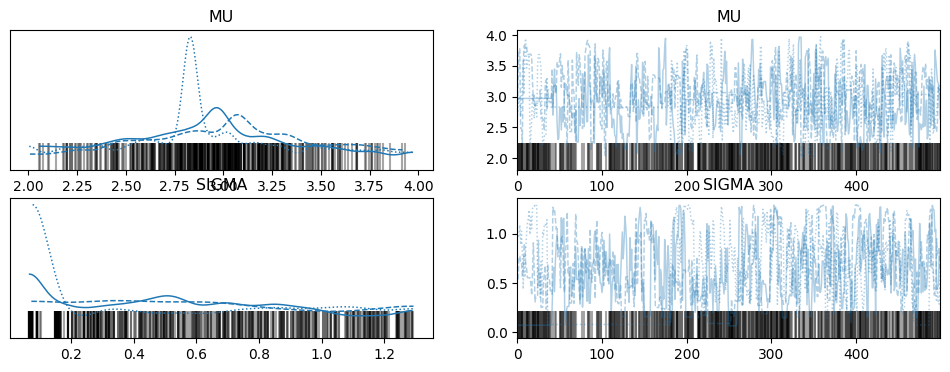

In [9]:
az.plot_trace(trace_NUTS, var_names=("MU", "SIGMA"))

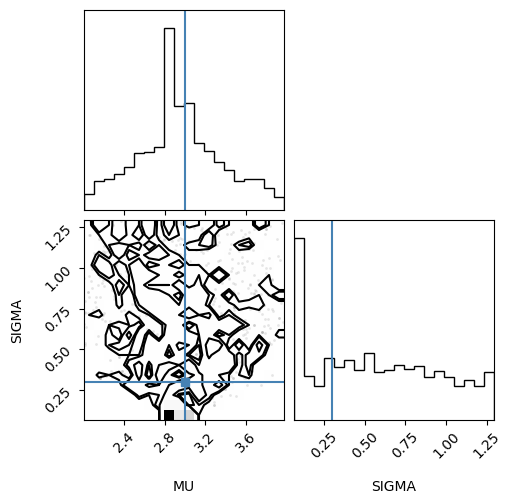

In [10]:
import corner
_ = corner.corner(trace_NUTS, var_names=["MU", "SIGMA"], 
                  truths=dict(MU=MU_DISTRIBUTION_POP, SIGMA=SIGMA_DISTRIBUTION_POP), show_titles=True)

## Everything is Gaussian (merger rate == $\sqrt{\text{population distribution}}$ == detection rate)

This means that mean remains same and variace is change : its shape is changed 

In [ ]:

MU_DISTRIBUTION_POP = 3
SIGMA_DISTRIBUTION_POP = .3

def population_dist(z):
    return st.norm.pdf(x=z, loc=MU_DISTRIBUTION_POP, scale=SIGMA_DISTRIBUTION_POP)

def merger_rate(z):
    # merger rate depends on the population distribution
    # the parameters of merger rate also depend on the 
    # parameter of the population distribution
    
    return population_dist(z)**.5

# TESTING DISTRIBUTIONS

z = np.linspace(1, Z_MAX, 100)
plt.plot(z, population_dist(z), label='$dN^s/dz$')
plt.plot(z, merger_rate(z), label='$d^2N^s/dzdt$')
plt.xlabel('z')
plt.legend()
del z

In [ ]:
# DISTRIBUTION FOR SOURCE DETECTION

z_events = np.random.choice(np.linspace(0, Z_MAX, SEEDS//2), size=SEEDS//2, p=merger_rate(np.linspace(0, Z_MAX, SEEDS//2)) / np.sum(merger_rate(np.linspace(0, Z_MAX, SEEDS//2))))
plt.hist(z_events, bins=50, fill=False, histtype='step')
plt.xlabel('$z$')
plt.ylabel('$d^2N^s_\\uparrow/dzdt$')

In [ ]:
# DEFINING THE POSTERIORS ON Z

LEN_DATA = 500
Z_SRC = np.empty((SEEDS//2, LEN_DATA))
for i in range(SEEDS//2):
    Z_SRC[i] = st.norm(loc=z_events[i], scale=0.5).rvs(size=LEN_DATA)

# PLOTTING ALL THE EVENTS' Z

for i in range(SEEDS//2):
    plt.hist(Z_SRC[i], fill=False, histtype='step', label=i)

In [ ]:
import pymc3 as pm

In [ ]:
with pm.Model() as model:
    MU = pm.Uniform('MU', lower=MU_DISTRIBUTION_POP-1, upper=MU_DISTRIBUTION_POP+1)
    SIGMA = pm.Uniform('SIGMA', lower=SIGMA_DISTRIBUTION_POP-.5, upper=SIGMA_DISTRIBUTION_POP+.5)
    prior = pm.Normal('mu', mu=MU, sigma=SIGMA)  # prior draws data points from hyperprior
    obs = pm.Normal('obs', mu=prior, sigma=0.5, observed=Z_SRC)  # likelihood draws data points from prior
    step = pm.Metropolis()
 
    # sample with 3 independent Markov chains
    trace = pm.sample(draws=500, chains=5, step=step, return_inferencedata=True, cores=2)

In [ ]:
az.summary(trace, var_names=["MU", "SIGMA"])["mean"]

In [ ]:
az.plot_trace(trace, var_names=("MU", "SIGMA"))

In [ ]:
import corner
_ = corner.corner(trace, var_names=["MU", "SIGMA"], 
                  truths=dict(MU=MU_DISTRIBUTION_POP, SIGMA=SIGMA_DISTRIBUTION_POP/np.sqrt(2))) # CHECK THIS 

# Only event parameter is Gaussian

In [ ]:
SEEDS = 2000
Z_MAX = 5

# DEFINING DISTRIBUTIONS 

ALPHA_DISTRIBUTION_POP = 5
BETA_DISTRIBUTION_POP = 1
MU_DISTRIBUTION_POP = 1
SIGMA_DISTRIBUTION_POP = 6

def population_dist(z, alpha):
    return BETA_DISTRIBUTION_POP*st.invgamma.pdf(x=z, a=alpha, loc=MU_DISTRIBUTION_POP, scale=SIGMA_DISTRIBUTION_POP)

def merger_rate(z, alpha):
    # merger rate depends on the population distribution
    # the parameters of merger rate also depend on the 
    # parameter of the population distribution
    
    return population_dist(z, alpha)


# TESTING DISTRIBUTIONS

z = np.linspace(1, Z_MAX, 100)
plt.plot(z, population_dist(z, alpha=ALPHA_DISTRIBUTION_POP), label='$N^s$')
plt.plot(z, merger_rate(z, alpha=ALPHA_DISTRIBUTION_POP), label='$dN^s/dt$')
plt.xlabel('z')
plt.legend()
del z

In [ ]:
# DISTRIBUTION FOR SOURCE DETECTION

z_events = np.random.choice(np.linspace(0, Z_MAX, SEEDS//2), size=SEEDS//2, p=merger_rate(np.linspace(0, Z_MAX, SEEDS//2), ALPHA_DISTRIBUTION_POP) / np.sum(merger_rate(np.linspace(0, Z_MAX, SEEDS//2), ALPHA_DISTRIBUTION_POP)))

#[np.random.poisson(30)/10 for _ in range(SEEDS//2)] # half the number of total population
plt.hist(z_events, bins=50, fill=False, histtype='step')
plt.xlabel('$z$')
plt.ylabel('$dN^s_\\uparrow/dz$')
print(len(z_events))

In [ ]:
# DEFINING THE POSTERIORS ON Z

LEN_DATA = 500
Z_SRC = np.empty((SEEDS//2, LEN_DATA))
for i in range(SEEDS//2):
    Z_SRC[i] = st.norm(loc=z_events[i], scale=0.5).rvs(size=LEN_DATA)

# PLOTTING ALL THE EVENTS' Z

for i in range(SEEDS//2):
    plt.hist(Z_SRC[i], fill=False, histtype='step', label=i)

In [ ]:
import pymc3 as pm

In [ ]:
with pm.Model() as model:
    alpha_merger_rate = pm.Uniform('ALPHA', lower=ALPHA_DISTRIBUTION_POP-2, upper=ALPHA_DISTRIBUTION_POP+2)
    #MU = pm.Uniform('MU', lower=MU_DISTRIBUTION_POP-1, upper=MU_DISTRIBUTION_POP+1)
    #SIGMA = pm.Uniform('SIGMA', lower=SIGMA_DISTRIBUTION_POP-1, upper=SIGMA_DISTRIBUTION_POP+1)
    prior = pm.InverseGamma('mu', beta=BETA_DISTRIBUTION_POP, alpha=alpha_merger_rate, mu=MU_DISTRIBUTION_POP, sigma=SIGMA_DISTRIBUTION_POP)  # prior draws data points from hyperprior
    obs = pm.Normal('obs', mu=prior, sigma=0.5, observed=Z_SRC)  # likelihood draws data points from prior
    step = pm.Metropolis()
 
    # sample with 3 independent Markov chains
    trace = pm.sample(draws=500, chains=2, step=step, return_inferencedata=True, cores=2)

In [ ]:
#az.summary(trace, var_names=["MU", "SIGMA", "ALPHA"])["mean"]
az.summary(trace, var_names=["ALPHA"])["mean"]

In [ ]:
#az.plot_trace(trace, var_names=("MU", "SIGMA", "ALPHA"))
az.plot_trace(trace, var_names=("ALPHA"))

In [ ]:
import corner
#_ = corner.corner(trace, var_names=["MU", "SIGMA", "ALPHA"], 
#                  truths=dict(MU=MU_DISTRIBUTION_POP, SIGMA=SIGMA_DISTRIBUTION_POP, ALPHA=ALPHA_DISTRIBUTION_POP/2))
_ = corner.corner(trace, var_names=["ALPHA"], 
                  truths=dict(ALPHA=ALPHA_DISTRIBUTION_POP))